# Data Assimilation for Numerical Modeling Final Project
* **Lorenz 96 model**
* **EKF / OI / 3DVAR / EnKF**

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import time

## Lorenz 96

In [2]:
def f(t, y, F):
    return (np.roll(y, -1) - np.roll(y, 2)) * np.roll(y, 1) - y + F

## Settings

In [3]:
# parameters
N = 40              # number of grid point
F = 8.0              # forcing term

Tmax = 10.          # time length of the experiment
dT = 0.05           # DA cycle length
nT = int(Tmax / dT) # number of cycles

## Nature run (no need to run again)

In [ ]:
# settings of spin-up
sigma_x0 = 0.05  # size of initial perturpation
Tspinup = 100.  # initial spin-up time

# spin-up from a random initail value
x_t_0 = sigma_x0 * np.random.randn(N)

solver = ode(f).set_integrator('dopri5', nsteps=10000)
solver.set_initial_value(x_t_0, 0.).set_f_params(F)
solver.integrate(Tspinup)
x_t_save = np.array([solver.y], dtype='f8')

# create nature
solver = ode(f).set_integrator('dopri5')
solver.set_initial_value(x_t_save[0], 0.).set_f_params(F)

tt = 1
while solver.successful() and tt <= nT:
    solver.integrate(solver.t + dT)
    x_t_save = np.vstack([x_t_save, [solver.y]])
#   print('timestep =', tt, round(solver.t, 10))
    tt += 1

# save data
np.savetxt('x_t.txt', x_t_save)

## Initial condition (no need to run again)

In [ ]:
# settings of spin-up
sigma_x0 = 0.1  # size of initial perturpation
Tspinup = 100.  # initial spin-up time

# spin-up from a random initail value
x_a_0 = sigma_x0 * np.random.randn(N)

solver = ode(f).set_integrator('dopri5', nsteps=10000)
solver.set_initial_value(x_a_0, 0.).set_f_params(F)
solver.integrate(Tspinup)
x_a_init = np.array(solver.y, dtype='f8')

# save the initial condition for DA experiment
np.savetxt('x_a_init.txt', x_a_init)

# Data Assmilation
### settings  (no need to run again)

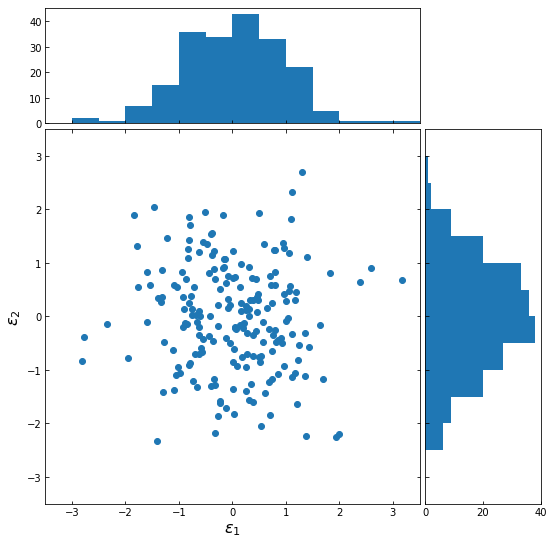

In [5]:
# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
x_a_save = np.array([x_a_init])

# load observations
x_t = np.genfromtxt('x_t.txt')
noise = np.random.normal(0, 1, x_t.shape) ## can change the error
y_o_save = x_t + noise  ###  Add random normal errors to the values in the nature run to create (a complete set of) simulated (synthetic) observations.
np.savetxt('y_o_save.txt', y_o_save)

bad_obs = [5,9,10,22,27] #list(np.random.choice(40, 5))
bad_add = np.zeros((201,40))
for i in range(201):
    for j in range(40):
        if j in bad_obs:
            bad_add[i,j] = np.random.choice([0, 1])*(np.random.randn(1)[0]*3)

y_o_save_bad = y_o_save + bad_add
np.savetxt('y_o_save_bad.txt', y_o_save_bad)

## Check the observation error distribution and correlation
e_1k = (y_o_save-x_t)[:,1]
e_2k = (y_o_save-x_t)[:,2]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))
ax_scatter = plt.axes(rect_scatter)
plt.xlabel('$\epsilon_1$',fontsize = 16)
plt.ylabel('$\epsilon_2$',fontsize = 16)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(e_1k, e_2k)

# now determine nice limits by hand:
binwidth = 0.5
lim = np.ceil(np.abs([e_1k, e_2k]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(e_1k, bins=bins)
ax_histy.hist(e_2k, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
#plt.savefig('checkrandom.png')
plt.show()

### plot bad observation example

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


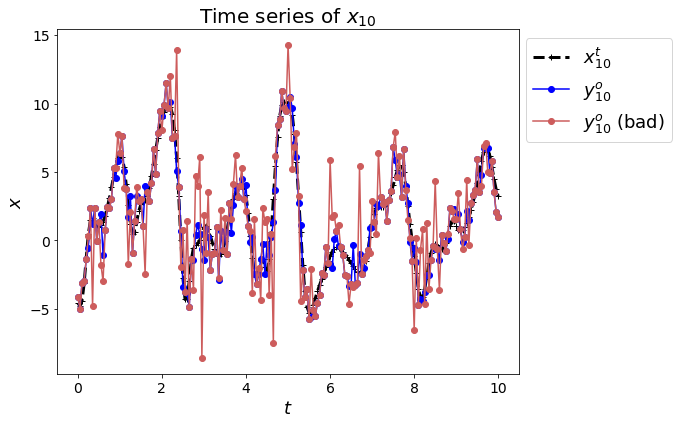

In [6]:
fig , ax = plt.subplots(figsize=(10,6),tight_layout=True)
pt = 10

plt.plot(np.arange(nT+1) * dT, x_t[:,pt], 'k+--', label=r'$x^t_{' + str(pt) + '}$',linewidth = 3)
plt.plot(np.arange(nT+1) * dT, y_o_save[:,pt], 'bo-' , label=r'$y^o_{' + str(pt) + '}$')
plt.plot(np.arange(nT+1) * dT, y_o_save_bad[:,pt],'o-', color = '#CD5C5C' , label=r'$y^o_{' + str(pt) + '}$ (bad)')
plt.xlabel(r'$t$', size=18)
plt.ylabel(r'$x$', size=18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
plt.legend(bbox_to_anchor=(1.35, 1),loc='upper right', numpoints=1, prop={'size':18})
#plt.savefig('timeseries_bad_obs.png', dpi=200)
plt.show()

### define a function for convenience

In [7]:
def DA_init(bad):
    # load initial condition
    x_a_init = np.genfromtxt('x_a_init.txt')
    x_a_save = np.array([x_a_init])
    if bad == False:
        y_o_save = np.genfromtxt('y_o_save.txt')
    elif bad == True:
        y_o_save = np.genfromtxt('y_o_save_bad.txt')
    
    # initial x_b: no values at the initial time (assign NaN)
    x_b_save = np.full((1,N), np.nan, dtype='f8')

    return x_a_init, x_a_save,y_o_save,x_b_save      

## No DA

In [ ]:
x_a_init, x_a_save,y_o_save,x_b_save = DA_init(True)

tt = 1
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))
    #--------------
    # forecast step
    #--------------
    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])

    #--------------
    # analysis step
    #--------------
    # background
    x_b = x_b_save[tt].transpose()

    # analysis scheme (No assimilation in this example)
    x_a = x_b
    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    tt += 1
# save background and analysis data
np.savetxt('x_b_noDA.txt', x_b_save)
np.savetxt('x_a_noDA.txt', x_a_save)

## DA methods: EKF

In [ ]:
x_a_init, x_a_save,y_o_save,x_b_save = DA_init(False)

tt = 1
e_o = np.var(noise, axis=0)
R = np.diag(e_o)
Pa = R
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))
    
    ##----- forecast step ------##  
    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])
    
    def ff(y):
        return (np.roll(y, -1) - np.roll(y, 2)) * np.roll(y, 1) - y + 8
    jacobian_f = jacobian(ff)
    JF = jacobian_f(solver.y)
    def f1(JF,Pa):
        return JF.dot(Pa)+JF.dot(Pa).T
    
    solver = ode(f1).set_integrator('dopri5')
    solver.set_initial_value(Pa, 0.)
    solver.integrate(x_b_save[tts])
    Pf = np.array([solver.y], dtype='f8')[0,:,:]
    
    ##------ analysis step------##  
    # background
    x_b = x_b_save[tt].transpose()

    # observation
    y_o = y_o_save[tt].transpose()
    # innovation
    H = np.eye(N)
    y_b = np.dot(H, x_b) ## background on observation domain
    d = y_o - y_b
    
    # observation error
    e_o = np.var(noise, axis=0)
    R = np.diag(e_o)
    # background error
    Pf = 1.2*Pf # inflation
    e_b = y_b - np.dot(H, x_t[tt].transpose())
    K = Pf.dot(H.T).dot(np.linalg.inv(H.dot(Pf).dot(H.T)+R))
    x_a = x_b + K.dot(y_o-H.dot(x_b))   
    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    Pa = (np.eye(N)-K.dot(H)).dot(Pf)
    tt += 1
# save background and analysis data
np.savetxt('x_b_EKF.txt', x_b_save)
np.savetxt('x_a_EKF.txt', x_a_save)

## DA methods: OI
### OI (Pb = R)

In [ ]:
x_a_init, x_a_save,y_o_save,x_b_save = DA_init(False)

tt = 1
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))

    #--------------
    # forecast step
    #--------------
    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])

    #--------------
    # analysis step
    #--------------
    # background
    x_b = x_b_save[tt].transpose()
    # observation
    y_o = y_o_save[tt].transpose()

    # innovation
    H = np.eye(N)
    y_b = np.dot(H, x_b) ## background on observation domain
    d = y_o - y_b
    
    # observation error
    e_o = np.var(noise, axis=0)
    R = np.diag(e_o)
    # background error    
    P = R
    e_b = y_b - np.dot(H, x_t[tt].transpose())
    K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T)+R))
    A = (np.eye(N)-K.dot(H)).dot(P)
    x_a = x_b + K.dot(y_o-H.dot(x_b))   

    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    tt += 1
# save background and analysis data
np.savetxt('x_b_OI.txt', x_b_save)
np.savetxt('x_a_OI.txt', x_a_save)

### NMC method (test alpha)

alpha =  0.9
alpha =  0.7
alpha =  0.6
alpha =  0.5
alpha =  0.3
alpha =  0.1


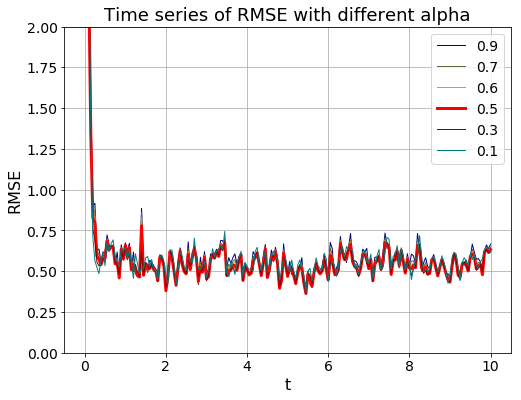

In [10]:
# load initial condition
alphas = [0.9,0.7,0.6,0.5,0.3,0.1]
RMSE= np.empty([201,])
fig , ax = plt.subplots(figsize=(8,6))
colors = ['#000080','#556B2F','#FF8C00','#FF0000','#800000','#008080']
linewidths = [1,1,1,3,1,1]
cl = 0
P_new_save = np.empty([201,40,40])
x_t_save = np.genfromtxt('x_t.txt')
for alpha in alphas:
    print('alpha = ',alpha)
    x_a_init, x_a_save,y_o_save,x_b_save = DA_init(False)
    Pb = R
    tt = 1
    P_new = np.empty([40,40])
    while tt <= nT:
        tts = tt - 1
        Ts = tts * dT  # forecast start time
        Ta = tt  * dT  # forecast end time (DA analysis time)
        #--------------
        # forecast step
        #--------------
        solver = ode(f).set_integrator('dopri5')
        solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
        solver.integrate(Ta)
        x_b_save = np.vstack([x_b_save, [solver.y]])

        #--------------
        # analysis step
        #--------------
        # background
        x_b = x_b_save[tt].transpose()
        # observation
        y_o = y_o_save[tt].transpose()

        # innovation
        H = np.eye(N)
        y_b = np.dot(H, x_b) ## background on observation domain
        d = y_o - y_b
        
        # observation error
        e_o = np.var(noise, axis=0)
        R = np.diag(e_o)
        # background error

        e_b = y_b - np.dot(H, x_t[tt].transpose())
        K = Pb.dot(H.T).dot(np.linalg.inv(H.dot(Pb).dot(H.T)+R))
        A = (np.eye(N)-K.dot(H)).dot(Pb)
        x_a = x_b + K.dot(y_o-H.dot(x_b))

        ## NMC method
        p_d = np.ones(20)
        if tt>2:
            x_p = x_a20-x_a11
            for i in range(20):
                tmp = []
                for j in range(N):
                    tmp.append(x_p[j-i]*x_p[j]) 
                p_d[i] =  np.mean(tmp) 
                for k in range(N):
                    P[k-i,k] = alpha*p_d[i]
                    P[k-39+i,k] = alpha*p_d[i]
            P_new = np.append(P_new,P, axis=0)
        else:
            P_new = np.append(P_new,P, axis=0)

        ## extend forecast
        if tt > 1:
            x_a20 = x_a21
        solver.integrate(Ta+dT)
        x_a11 = solver.y
        solver.integrate(Ta+2*dT)
        x_a21 = solver.y

        tt += 1
        x_a_save = np.vstack([x_a_save, x_a.transpose()])
    P_new = np.reshape(P_new,[201,40,40])
    P_new_save = np.append(P_new_save,P_new)
    
    x_a_save = np.array([x_a_init])
    tt = 1
    while tt <= nT:
        tts = tt - 1
        Ts = tts * dT  # forecast start time
        Ta = tt  * dT  # forecast end time (DA analysis time)

        #--------------
        # forecast step
        #--------------
        solver = ode(f).set_integrator('dopri5')
        solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
        solver.integrate(Ta)
        x_b_save = np.vstack([x_b_save, [solver.y]])

        #--------------
        # analysis step
        #--------------
        # background
        x_b = x_b_save[tt].transpose()
        # observation
        y_o = y_o_save[tt].transpose()

        # innovation
        H = np.eye(N)
        y_b = np.dot(H, x_b) ## background on observation domain
        d = y_o - y_b

        # observation error
        e_o = np.var(noise, axis=0)
        R = np.diag(e_o)
        # background error   
        P = P_new[tts,:,:]
        e_b = y_b - np.dot(H, x_t[tt].transpose())
        K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T)+R))
        A = (np.eye(N)-K.dot(H)).dot(P)
        x_a = x_b + K.dot(y_o-H.dot(x_b))   

        x_a_save = np.vstack([x_a_save, x_a.transpose()])
        tt += 1
        
    RMSE_OI_NMC = mean_squared_error(x_a_save.T,x_t_save.T, multioutput='raw_values')**0.5
    
    plt.plot(np.arange(nT+1) * dT,RMSE_OI_NMC,color = colors[cl],linewidth = linewidths[cl],label = f'{alpha}')
    cl += 1
    plt.ylim([0,2])
    plt.grid(True)
    plt.title('Time series of RMSE with different alpha',fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('t',fontsize = 16)
    plt.ylabel('RMSE',fontsize = 16)
    plt.legend(prop={'size':14})
    RMSE = np.append(RMSE,RMSE_OI_NMC, axis=0)

### NMC

In [ ]:
# load initial condition
P_new_save = np.reshape(P_new_save,[7,201,40,40])  # reshape the array from the testing above
P_new = P_new_save[4,:,:,:]  # alpha = 0.5
x_a_init, x_a_save,y_o_save,x_b_save = DA_init(False)

tt = 1
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))

    #--------------
    # forecast step
    #--------------
    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])

    #--------------
    # analysis step
    #--------------
    # background
    x_b = x_b_save[tt].transpose()
    # observation
    y_o = y_o_save[tt].transpose()

    # innovation
    H = np.eye(N)
    y_b = np.dot(H, x_b) ## background on observation domain
    d = y_o - y_b

    # observation error
    e_o = np.var(noise, axis=0)
    R = np.diag(e_o)
    # background error   
    P = P_new[tts,:,:]
    e_b = y_b - np.dot(H, x_t[tt].transpose())
    K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T)+R))
    A = (np.eye(N)-K.dot(H)).dot(P)
    x_a = x_b + K.dot(y_o-H.dot(x_b))   

    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    tt += 1
# save background and analysis data
np.savetxt('x_b_OI_NMC.txt', x_b_save)
np.savetxt('x_a_OI_NMC.txt', x_a_save)

## 3DVAR

In [ ]:
x_a_init, x_a_save,y_o_save,x_b_save = DA_init(False)

# observation error
e_o = np.var(noise, axis=0)
R = np.diag(e_o)

tt = 1
nT = int(Tmax / dT)
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))

    #--------------
    # forecast step
    #--------------
    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])

    #--------------
    # analysis step
    #--------------
    # background
    x_b = x_b_save[tt].transpose()
    # observation
    y_o = y_o_save[tt].transpose()
    x_g = x_b
    
    # innovation
    H = np.eye(N)
    y_b = np.dot(H, x_g) ## background on observation domain
    d = y_o - y_b
    
    # background error   
    P = P_new[tts,:,:]
    e_b = y_b - np.dot(H, x_t[tt].transpose())
    K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T)+R))
    A = (np.eye(N)-K.dot(H)).dot(P)
    
    ### Jacobian ###
    def J(x):
        return 0.5*(x_b-x).T.dot(np.linalg.inv(P)).dot(x_b-x) + 0.5*(y_o-np.dot(H, x_b)).T.dot(np.linalg.inv(R)).dot(y_o-np.dot(H, x_b))
    
    theta = np.ones([40,])
    dx = x_g
    try:
        fun = J(dx)
        res = minimize(J,x0=theta,method='TNC')
    except:
        P = P + 0.001*np.eye(N)  ## solve singular matrix problem
        fun = J(dx)
        res = minimize(J,x0=theta,method='TNC')
    
    # first guess update
    x_g = x_g + res.x
    x_a = x_b + K.dot(y_o-H.dot(x_b))  
    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    tt += 1
# save background and analysis data
np.savetxt('x_b_3DVAR.txt', x_b_save)
np.savetxt('x_a_3DVAR.txt', x_a_save)

## EnKF

In [ ]:
Nmember = 10
start = time.time()
r=np.mean(R.diagonal())
x_a_initEn = np.ones((Nmember,N))
x_a_init=np.loadtxt('x_a_init.txt')
x_a_initEn *= x_a_init.reshape(1,N)
x_a_initEn[1:,:] += np.random.normal(0,r,(Nmember-1,N))
# save the initial condition for DA experiment
np.savetxt('x_a_initEn10.txt', x_a_initEn)
# load initial condition
x_a_init_member = np.loadtxt('x_a_initEn10.txt').T

# load observations
y_o_save = np.genfromtxt('y_o_save.txt')
r = R.diagonal().mean()

# initial x_b: no values at the initial time (assign NaN)
x_b_save = np.full((1,N), np.nan, dtype='f8')

# initial x_a: from x_a_init
x_a_save = np.array([x_a_init_member])
x_a_bar_save = x_a_save.mean(axis=2).reshape(N,1)
x_a_per_save = x_a_save-x_a_bar_save.reshape(1,N,1)

# Operator operation
H = np.eye(N)
func_HXen = lambda x : H@x.reshape(N,1)

L=1
xx,yy=np.meshgrid(np.arange(N),np.arange(N))
Localization = np.exp(-1*(xx-yy)**2/2/L**2)

tt = 1
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))

    #--------------
    # forecast step
    #--------------
    x_b_member = np.zeros((N,Nmember))*np.nan
    for imember in np.arange(Nmember):
        xinput = x_a_save[tts,:,imember]
        solver = ode(f).set_integrator('dopri5')
        solver.set_initial_value(xinput, Ts).set_f_params(F)
        solver.integrate(Ta)
        #print(solver.y)
        x_b_member[:,imember] = solver.y

    #--------------
    # analysis step
    #--------------
    #inflaction = 1.01
    #x_b_member *= inflaction
    x_b_bar = x_b_member.mean(axis=1).reshape(N,1)
    x_b_per = x_b_member-x_b_bar
    HXb_member = np.apply_along_axis(func_HXen,0,x_b_member)[:,0,:]
    HXb_bar = HXb_member.mean(axis=1).reshape(N,1)
    PfHt = np.zeros((N,N))
    HPfHt = np.zeros((N,N))
    for imember in np.arange(Nmember):
        c = HXb_member[:,imember].reshape(N,1)-HXb_bar
        PfHt += np.matmul(x_b_per[:,imember].reshape(N,1), c.T)/(Nmember-1)
        HPfHt += np.matmul(c,c.T)/(Nmember-1)
    PfHt = Localization.dot(H.T)*PfHt
    HPfHt = H.dot(Localization).dot(H.T)*HPfHt
    #PfHt = Localization*PfHt
    #HPfHt = Localization*HPfHt
    K = PfHt@np.linalg.inv((HPfHt+R))
    y_o_member = y_o_save[tt].reshape(N,1)+np.random.normal(0,r,(N,Nmember)) 
    x_a_member = x_b_member+K@(y_o_member-HXb_member)
    x_a_bar = x_a_member.mean(axis=1)

    x_a_bar_save = np.hstack((x_a_bar_save,x_a_bar.reshape(N,1)))
    x_a_save = np.vstack((x_a_save,(x_a_member).reshape(1,N,Nmember)))

    tt += 1
end = time.time()
print(end-start)
# save background and analysis data
np.savetxt('x_a_EnKF10.txt', x_a_bar_save.T) #(nT+1,N)

## Plot result

### plot all RMSE

Text(0, 0.5, 'RMSE')

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


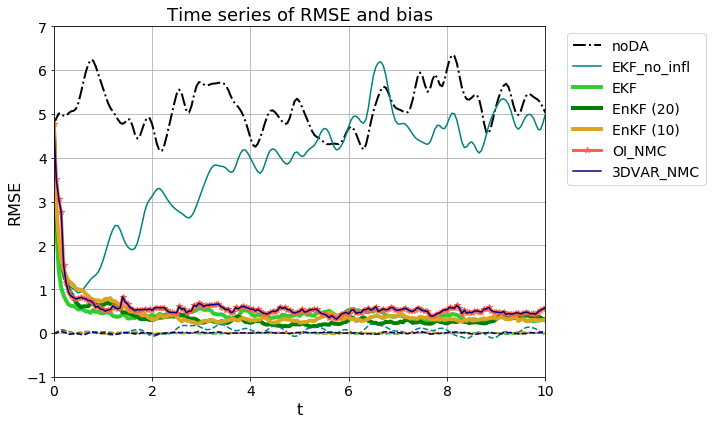

In [14]:
x_EKF = np.genfromtxt('x_a_EKF.txt')
x_EKF_no = np.genfromtxt('x_a_EKF_no.txt')
x_EnKF20 = np.genfromtxt('x_a_EnKF20.txt')
x_EnKF10 = np.genfromtxt('x_a_EnKF101.txt')
x_OI_NMC = np.genfromtxt('x_a_OI_NMC.txt')
x_3DVAR_NMC = np.genfromtxt('x_a_3DVAR.txt')
x_noDA = np.genfromtxt('x_a_noDA.txt')

fig , ax = plt.subplots(figsize=(10,6),tight_layout=True)

RMSE_EKF = mean_squared_error(x_EKF.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EKF_no = mean_squared_error(x_EKF_no.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF = mean_squared_error(x_EnKF20.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF10 = mean_squared_error(x_EnKF10.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_OI_NMC = mean_squared_error(x_OI_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC = mean_squared_error(x_3DVAR_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_noDA = mean_squared_error(x_noDA.T,x_t_save.T, multioutput='raw_values')**0.5
bias_EKF = np.sum((x_EKF-x_t_save)/len(x_t_save),axis = 1)
bias_EKF_no = np.sum((x_EKF_no-x_t_save)/len(x_t_save),axis = 1)
bias_EnKF = np.sum((x_EnKF20-x_t_save)/len(x_t_save),axis = 1)
bias_EnKF10 = np.sum((x_EnKF10-x_t_save)/len(x_t_save),axis = 1)
bias_OI_NMC = np.sum((x_OI_NMC-x_t_save)/len(x_t_save),axis = 1)
bias_3DVAR_NMC = np.sum((x_3DVAR_NMC-x_t_save)/len(x_t_save),axis = 1)

plt.plot(np.arange(nT+1) * dT,RMSE_noDA,'-.', color = '#000000',linewidth = 2,label = 'noDA')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF_no, color = '#008080',label = 'EKF_no_infl')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF, color = '#32CD32',linewidth = 4, label = 'EKF')
plt.plot(np.arange(nT+1) * dT,RMSE_EnKF, color = '#008000',linewidth = 4, label = 'EnKF (20)')
plt.plot(np.arange(nT+1) * dT,RMSE_EnKF10, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
plt.plot(np.arange(nT+1) * dT,RMSE_OI_NMC,'*-', color = '#FF6347',linewidth = 3, label = 'OI_NMC')
plt.plot(np.arange(nT+1) * dT,RMSE_3DVAR_NMC, color = '#000080', label = '3DVAR_NMC')

plt.plot(np.arange(nT+1) * dT,bias_EKF_no,'--', color = '#008080')
plt.plot(np.arange(nT+1) * dT,bias_EKF,'--', color = '#32CD32')
plt.plot(np.arange(nT+1) * dT,bias_EnKF,'--', color = '#008000')
plt.plot(np.arange(nT+1) * dT,bias_EnKF10,'--', color = '#DAA520')
plt.plot(np.arange(nT+1) * dT,bias_OI_NMC,'--', color = '#FF6347')
plt.plot(np.arange(nT+1) * dT,bias_3DVAR_NMC,'--', color = '#000080')

plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left',prop={'size':14})
plt.title('Time series of RMSE and bias',fontsize = 18)
plt.xlim([0,10])
plt.ylim([-1,7])
plt.grid()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('t',fontsize = 16)
plt.ylabel('RMSE',fontsize = 16)
#plt.savefig('RMSE_all.png')

### plot EKF (inflation)

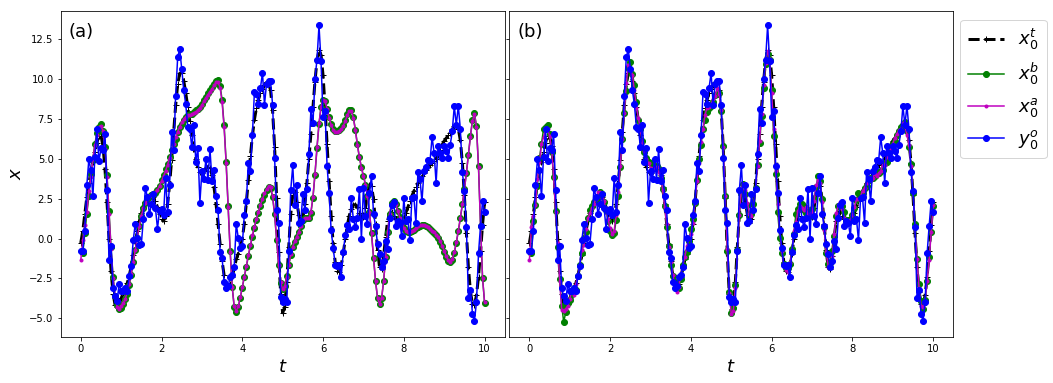

In [11]:
# load data
x_b_save = np.genfromtxt('x_b_EKF_no.txt')
x_a_save = np.genfromtxt('x_a_EKF_no.txt')
y_o_save = np.genfromtxt('y_o_save.txt')

# Plot time series of a single grid point
pt = 0
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), sharey=True)
fig.subplots_adjust(wspace=0.01)
ax1.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$',linewidth = 3)
ax1.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
ax1.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'mo-' , markersize=3,label=r'$x^a_{' + str(pt) + '}$')
ax1.plot(np.arange(nT+1) * dT, y_o_save[:,pt-1], 'bo-' , label=r'$y^o_{' + str(pt) + '}$')

ax1.set_xlabel(r'$t$', size=18)
ax1.set_ylabel(r'$x$', size=18)
ax1.annotate('(a)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)

# load data
x_b_save = np.genfromtxt('x_b_EKF.txt')
x_a_save = np.genfromtxt('x_a_EKF.txt')

# Plot time series of a single grid point
ax2.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$',linewidth = 3)
ax2.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
ax2.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'mo-' , markersize=3,label=r'$x^a_{' + str(pt) + '}$')
ax2.plot(np.arange(nT+1) * dT, y_o_save[:,pt-1], 'bo-' , label=r'$y^o_{' + str(pt) + '}$')

ax2.set_xlabel(r'$t$', size=18)
plt.annotate('(b)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)
plt.legend(bbox_to_anchor=(1.23, 1),loc='upper right', numpoints=1, prop={'size':18})

#plt.savefig('timeseries_EKF_no.png', dpi=200)
plt.show()

### plot OI & 3DVAR

Text(0, 0.5, 'RMSE')

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


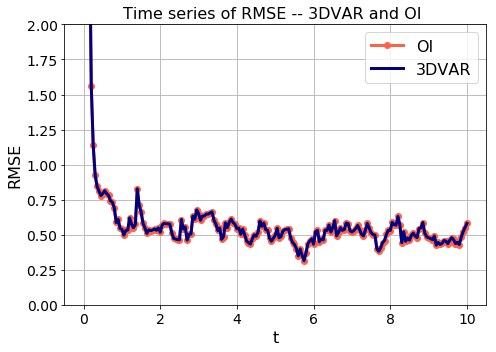

In [12]:
x_OI_NMC = np.genfromtxt('x_a_OI_NMC.txt')
x_3DVAR_NMC = np.genfromtxt('x_a_3DVAR.txt')
RMSE_OI_NMC = mean_squared_error(x_OI_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC = mean_squared_error(x_3DVAR_NMC.T,x_t_save.T, multioutput='raw_values')**0.5

fig , ax = plt.subplots(figsize=(7,5),tight_layout=True)
plt.plot(np.arange(nT+1) * dT,RMSE_OI_NMC, 'o-',color = '#FF6347',linewidth = 3, label = 'OI')
plt.plot(np.arange(nT+1) * dT,RMSE_3DVAR_NMC, color = '#000080',linewidth = 3, label = '3DVAR')
plt.legend(prop={'size':16})
plt.title('Time series of RMSE -- 3DVAR and OI ',fontsize = 16)
plt.ylim([0,2])
plt.grid()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('t',fontsize = 16)
plt.ylabel('RMSE',fontsize = 16)
#plt.savefig('RMSE_OI_3DVAR.png')

### plot KF

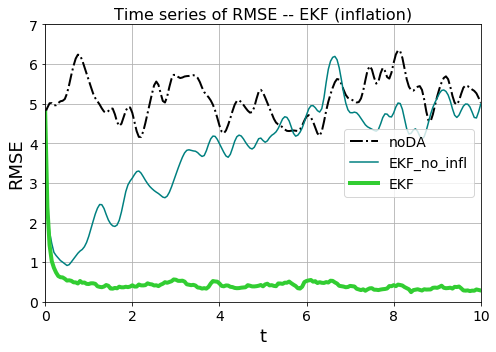

In [16]:
fig , ax = plt.subplots(figsize=(7,5),tight_layout=True)
#plt.plot(np.arange(nT+1) * dT,RMSE_EnKF101, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
#plt.plot(np.arange(nT+1) * dT,RMSE_EnKF20, color = '#008000',linewidth = 4, label = 'EnKF (20)')
#plt.plot(np.arange(nT+1) * dT,RMSE_EnKF30, color = '#0000CD',linewidth = 2, label = 'EnKF (30)')
plt.plot(np.arange(nT+1) * dT,RMSE_noDA,'-.', color = '#000000',linewidth = 2,label = 'noDA')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF_no, color = '#008080',label = 'EKF_no_infl')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF, color = '#32CD32',linewidth = 4, label = 'EKF')
plt.legend(prop={'size':14})
#plt.legend(bbox_to_anchor=(1,0.5),prop={'size':14})
plt.xlim([0,10])
plt.ylim([0,7])
plt.xlabel('t', size=18)
plt.ylabel('RMSE', size=18)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14) 
plt.grid()
plt.title('Time series of RMSE -- EKF (inflation)', size=16)
#plt.savefig('RMSE_EnKF_all.png')
plt.show()

### plot EnKF (5 tests)

Text(0.5, 1.0, 'Time series of RMSE -- EnKF')

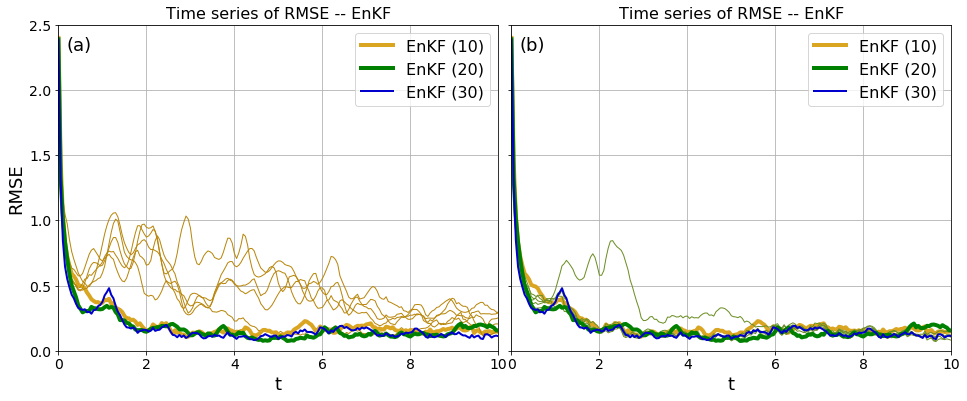

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), sharey=True)
fig.subplots_adjust(wspace=0.03)

x_EKF = np.genfromtxt('x_a_EKF.txt')
x_EKF_no = np.genfromtxt('x_a_EKF_no.txt')
x_EnKF10 = np.genfromtxt('x_a_EnKF10.txt')
x_EnKF101 = np.genfromtxt('x_a_EnKF101.txt')
x_EnKF102 = np.genfromtxt('x_a_EnKF102.txt')
x_EnKF103 = np.genfromtxt('x_a_EnKF103.txt')
x_EnKF104 = np.genfromtxt('x_a_EnKF104.txt')
x_EnKF105 = np.genfromtxt('x_a_EnKF105.txt')
x_EnKF20 = np.genfromtxt('x_a_EnKF20.txt')
x_EnKF30 = np.genfromtxt('x_a_EnKF30.txt')
RMSE_EKF = mean_squared_error(x_EKF.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EKF_no = mean_squared_error(x_EKF_no.T,x_t_save.T, multioutput='raw_values')**0.5

RMSE_EnKF10 = mean_squared_error(x_EnKF10.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF101 = mean_squared_error(x_EnKF101.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF102 = mean_squared_error(x_EnKF102.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF103 = mean_squared_error(x_EnKF103.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF104 = mean_squared_error(x_EnKF104.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF105 = mean_squared_error(x_EnKF105.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF20 = mean_squared_error(x_EnKF20.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF30 = mean_squared_error(x_EnKF30.T,x_t_save.T, multioutput='raw_values')**0.5

ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF10, color = '#B8860B',linewidth = 1)
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF101, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF102, color = '#B8860B',linewidth = 1)
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF103, color = '#B8860B',linewidth = 1)
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF104, color = '#B8860B',linewidth = 1)
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF105, color = '#B8860B',linewidth = 1)
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF20, color = '#008000',linewidth = 4, label = 'EnKF (20)')
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF30, color = '#0000CD',linewidth = 2, label = 'EnKF (30)')
ax1.annotate('(a)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)
ax1.legend(prop={'size':16})
ax1.set_xlim([0,10])
ax1.set_ylim([0,3])
ax1.set_xlabel('t', size=18)
ax1.set_ylabel('RMSE', size=18)
ax1.set_xticklabels([0,2,4,6,8,10],fontsize=14) 
ax1.set_yticklabels(list(np.linspace(0,3,7)),fontsize=14) 
ax1.grid()
ax1.set_title('Time series of RMSE -- EnKF', size=16)

x_EnKF201 = np.genfromtxt('x_a_EnKF201.txt')
x_EnKF202 = np.genfromtxt('x_a_EnKF202.txt')
x_EnKF203 = np.genfromtxt('x_a_EnKF203.txt')
x_EnKF204 = np.genfromtxt('x_a_EnKF204.txt')
x_EnKF205 = np.genfromtxt('x_a_EnKF205.txt')

RMSE_EnKF10 = mean_squared_error(x_EnKF101.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF201 = mean_squared_error(x_EnKF201.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF202 = mean_squared_error(x_EnKF202.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF203 = mean_squared_error(x_EnKF203.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF204 = mean_squared_error(x_EnKF204.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF205 = mean_squared_error(x_EnKF205.T,x_t_save.T, multioutput='raw_values')**0.5

ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF10, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF201, color = '#6B8E23',linewidth = 1)
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF202, color = '#6B8E23',linewidth = 1)
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF203, color = '#6B8E23',linewidth = 1)
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF204, color = '#6B8E23',linewidth = 1)
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF205, color = '#6B8E23',linewidth = 1)
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF20, color = '#008000',linewidth = 4, label = 'EnKF (20)')
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF30, color = '#0000CD',linewidth = 2, label = 'EnKF (30)')
ax2.annotate('(b)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)
plt.legend(prop={'size':16})
ax2.set_xlim([0,10])
ax2.set_ylim([0,5])
ax2.set_xlabel('t', size=18)
ax2.set_xticklabels([0,2,4,6,8,10],fontsize=14) 
ax2.grid()
ax2.set_title('Time series of RMSE -- EnKF', size=16)

#plt.savefig('RMSE_EnKF1020.png')

### plot all RMSE (bad)

Text(0, 0.5, 'RMSE')

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


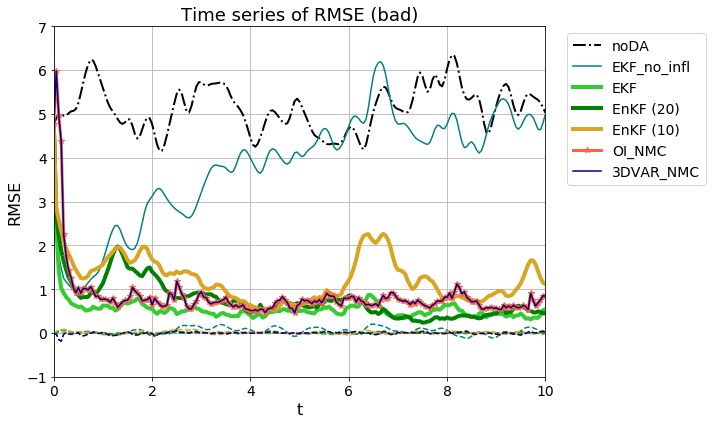

In [18]:
x_EKF = np.genfromtxt('x_a_EKF_bad.txt')
x_EKF_no = np.genfromtxt('x_a_EKF_no.txt')
x_EnKF20 = np.genfromtxt('x_a_EnKF20_bad.txt')
x_EnKF10 = np.genfromtxt('x_a_EnKF10_bad.txt')
x_OI_NMC = np.genfromtxt('x_a_OI_NMC_bad.txt')
x_3DVAR_NMC = np.genfromtxt('x_a_3DVAR_bad.txt')
x_noDA = np.genfromtxt('x_a_noDA.txt')

fig , ax = plt.subplots(figsize=(10,6),tight_layout=True)

RMSE_EKF = mean_squared_error(x_EKF.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EKF_no = mean_squared_error(x_EKF_no.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF = mean_squared_error(x_EnKF20.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF10 = mean_squared_error(x_EnKF10.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_OI_NMC = mean_squared_error(x_OI_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC = mean_squared_error(x_3DVAR_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_noDA = mean_squared_error(x_noDA.T,x_t_save.T, multioutput='raw_values')**0.5
bias_EKF = np.sum((x_EKF-x_t_save)/len(x_t_save),axis = 1)
bias_EKF_no = np.sum((x_EKF_no-x_t_save)/len(x_t_save),axis = 1)
bias_EnKF = np.sum((x_EnKF20-x_t_save)/len(x_t_save),axis = 1)
bias_EnKF10 = np.sum((x_EnKF10-x_t_save)/len(x_t_save),axis = 1)
bias_OI_NMC = np.sum((x_OI_NMC-x_t_save)/len(x_t_save),axis = 1)
bias_3DVAR_NMC = np.sum((x_3DVAR_NMC-x_t_save)/len(x_t_save),axis = 1)

plt.plot(np.arange(nT+1) * dT,RMSE_noDA,'-.', color = '#000000',linewidth = 2,label = 'noDA')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF_no, color = '#008080',label = 'EKF_no_infl')
plt.plot(np.arange(nT+1) * dT,RMSE_EKF, color = '#32CD32',linewidth = 4, label = 'EKF')
plt.plot(np.arange(nT+1) * dT,RMSE_EnKF, color = '#008000',linewidth = 4, label = 'EnKF (20)')
plt.plot(np.arange(nT+1) * dT,RMSE_EnKF10, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
plt.plot(np.arange(nT+1) * dT,RMSE_OI_NMC,'*-', color = '#FF6347',linewidth = 3, label = 'OI_NMC')
plt.plot(np.arange(nT+1) * dT,RMSE_3DVAR_NMC, color = '#000080', label = '3DVAR_NMC')

plt.plot(np.arange(nT+1) * dT,bias_EKF_no,'--', color = '#008080')
plt.plot(np.arange(nT+1) * dT,bias_EKF,'--', color = '#32CD32')
plt.plot(np.arange(nT+1) * dT,bias_EnKF,'--', color = '#008000')
plt.plot(np.arange(nT+1) * dT,bias_EnKF10,'--', color = '#DAA520')
plt.plot(np.arange(nT+1) * dT,bias_OI_NMC,'--', color = '#FF6347')
plt.plot(np.arange(nT+1) * dT,bias_3DVAR_NMC,'--', color = '#000080')

plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left',prop={'size':14})
plt.title('Time series of RMSE (bad)',fontsize = 18)
plt.xlim([0,10])
plt.ylim([-1,7])
plt.grid()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('t',fontsize = 16)
plt.ylabel('RMSE',fontsize = 16)
#plt.savefig('RMSE_all_bad.png')

### RMSE time series difference  & only bad

[Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10')]

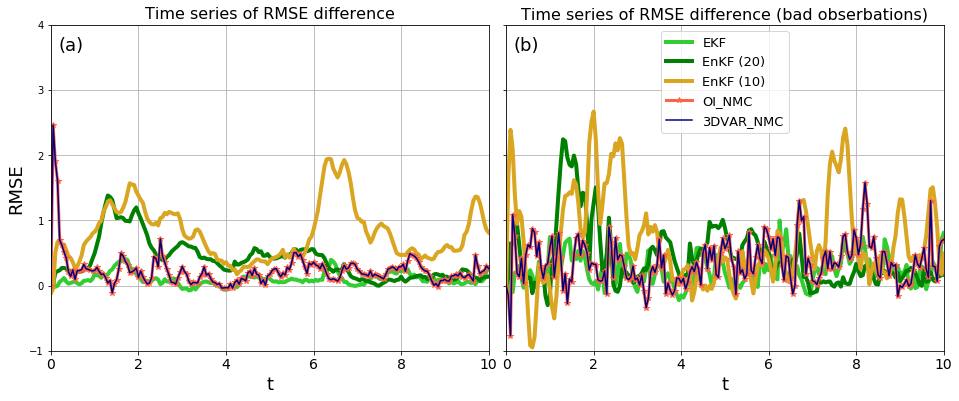

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), sharey=True)
fig.subplots_adjust(wspace=0.04)

x_EKF1 = np.genfromtxt('x_a_EKF_bad.txt')
x_EnKF201 = np.genfromtxt('x_a_EnKF20_bad.txt')
x_EnKF101 = np.genfromtxt('x_a_EnKF10_bad.txt')
x_OI_NMC1 = np.genfromtxt('x_a_OI_NMC_bad.txt')
x_3DVAR_NMC1 = np.genfromtxt('x_a_3DVAR_bad.txt')

x_EKF = np.genfromtxt('x_a_EKF.txt')
x_EnKF20 = np.genfromtxt('x_a_EnKF20.txt')
x_EnKF10 = np.genfromtxt('x_a_EnKF101.txt')
x_OI_NMC = np.genfromtxt('x_a_OI_NMC.txt')
x_3DVAR_NMC = np.genfromtxt('x_a_3DVAR.txt')

RMSE_EKF1 = mean_squared_error(x_EKF1.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF201 = mean_squared_error(x_EnKF201.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF101 = mean_squared_error(x_EnKF101.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_OI_NMC1 = mean_squared_error(x_OI_NMC1.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC1 = mean_squared_error(x_3DVAR_NMC1.T,x_t_save.T, multioutput='raw_values')**0.5

RMSE_EKF = mean_squared_error(x_EKF.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF20 = mean_squared_error(x_EnKF20.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_EnKF10 = mean_squared_error(x_EnKF10.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_OI_NMC = mean_squared_error(x_OI_NMC.T,x_t_save.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC = mean_squared_error(x_3DVAR_NMC.T,x_t_save.T, multioutput='raw_values')**0.5

ax1.plot(np.arange(nT+1) * dT,RMSE_EKF1-RMSE_EKF, color = '#32CD32',linewidth = 4, label = 'EKF')
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF201-RMSE_EnKF20, color = '#008000',linewidth = 4, label = 'EnKF (20)')
ax1.plot(np.arange(nT+1) * dT,RMSE_EnKF101-RMSE_EnKF10, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
ax1.plot(np.arange(nT+1) * dT,RMSE_OI_NMC1-RMSE_OI_NMC,'*-', color = '#FF6347',linewidth = 3, label = 'OI_NMC')
ax1.plot(np.arange(nT+1) * dT,RMSE_3DVAR_NMC1-RMSE_3DVAR_NMC, color = '#000080', label = '3DVAR_NMC')
ax1.annotate('(a)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)
ax1.set_xlabel('t', size=18)
ax1.set_ylabel('RMSE', size=18)
ax1.set_xlim([0,10])
ax1.set_ylim([-1,4])
ax1.set_xticklabels([0,2,4,6,8,10],fontsize=14) 
ax1.grid()
ax1.set_title('Time series of RMSE difference', size=16)

x_t_save1 = np.genfromtxt('x_t.txt')[:, [5, 9, 10, 22, 27]]
x_EKF1 = np.genfromtxt('x_a_EKF_bad.txt')[:, [5, 9, 10, 22, 27]]
x_EnKF201 = np.genfromtxt('x_a_EnKF20_bad.txt')[:, [5, 9, 10, 22, 27]]
x_EnKF101 = np.genfromtxt('x_a_EnKF10_bad.txt')[:, [5, 9, 10, 22, 27]]
x_OI_NMC1 = np.genfromtxt('x_a_OI_NMC_bad.txt')[:, [5, 9, 10, 22, 27]]
x_3DVAR_NMC1 = np.genfromtxt('x_a_3DVAR_bad.txt')[:, [5, 9, 10, 22, 27]]

x_EKF = np.genfromtxt('x_a_EKF.txt')[:, [5, 9, 10, 22, 27]]
x_EnKF20 = np.genfromtxt('x_a_EnKF20.txt')[:, [5, 9, 10, 22, 27]]
x_EnKF10 = np.genfromtxt('x_a_EnKF101.txt')[:, [5, 9, 10, 22, 27]]
x_OI_NMC = np.genfromtxt('x_a_OI_NMC.txt')[:, [5, 9, 10, 22, 27]]
x_3DVAR_NMC = np.genfromtxt('x_a_3DVAR.txt')[:, [5, 9, 10, 22, 27]]

RMSE_EKF1 = mean_squared_error(x_EKF1.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_EnKF201 = mean_squared_error(x_EnKF201.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_EnKF101 = mean_squared_error(x_EnKF101.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_OI_NMC1 = mean_squared_error(x_OI_NMC1.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC1 = mean_squared_error(x_3DVAR_NMC1.T,x_t_save1.T, multioutput='raw_values')**0.5

RMSE_EKF = mean_squared_error(x_EKF.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_EnKF20 = mean_squared_error(x_EnKF20.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_EnKF10 = mean_squared_error(x_EnKF10.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_OI_NMC = mean_squared_error(x_OI_NMC.T,x_t_save1.T, multioutput='raw_values')**0.5
RMSE_3DVAR_NMC = mean_squared_error(x_3DVAR_NMC.T,x_t_save1.T, multioutput='raw_values')**0.5

ax2.plot(np.arange(nT+1) * dT,RMSE_EKF1-RMSE_EKF, color = '#32CD32',linewidth = 4, label = 'EKF')
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF201-RMSE_EnKF20, color = '#008000',linewidth = 4, label = 'EnKF (20)')
ax2.plot(np.arange(nT+1) * dT,RMSE_EnKF101-RMSE_EnKF10, color = '#DAA520',linewidth = 4, label = 'EnKF (10)')
ax2.plot(np.arange(nT+1) * dT,RMSE_OI_NMC1-RMSE_OI_NMC,'*-', color = '#FF6347',linewidth = 3, label = 'OI_NMC')
ax2.plot(np.arange(nT+1) * dT,RMSE_3DVAR_NMC1-RMSE_3DVAR_NMC, color = '#000080', label = '3DVAR_NMC')
ax2.annotate('(b)', xy=(0.018, 0.92), xycoords='axes fraction', fontsize=18)

plt.legend(prop={'size':13})
plt.title('Time series of RMSE difference (bad obserbations)',fontsize = 16)
plt.grid()
ax2.set_xlabel('t', size=18)
ax2.set_xlim([0,10])
ax2.set_xticklabels([0,2,4,6,8,10],fontsize=14)  
#plt.savefig('RMSE_dif_both.png')